# Policy Evaluation (Prediction) vs. Control

## Policy Evaluation

- *Policy Evaluation* is the task of determining the state-value function $v_\pi$, for a particular policy $\pi$

$$
\pi,p,\gamma \rightarrow \text{(Dynamic Programming)} \rightarrow v_\pi
$$

## Control

- *Control* is the task of improving an existing policy

$$
p,\gamma \rightarrow \text{(Dynamic Programming)} \rightarrow \pi_\star
$$

## Iterative Policy Evaluation

$$
v_{k+1}(s) \leftarrow \sum_{a}\pi(a|s)\sum_{s',r}p(s',r|s,a)[r + \gamma v_k(s')]
$$

## Example: Convergence of iterative policy evaluation on a small gridworld

In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table

WORLD_SIZE = 4
# left, up, right, down
ACTIONS = [np.array([0, -1]),
           np.array([-1, 0]),
           np.array([0, 1]),
           np.array([1, 0])]
ACTION_PROB = 0.25


def is_terminal(state):
    x, y = state
    return (x == 0 and y == 0) or (x == WORLD_SIZE - 1 and y == WORLD_SIZE - 1)


def step(state, action):
    if is_terminal(state):
        return state, 0

    next_state = (np.array(state) + action).tolist()
    x, y = next_state

    if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
        next_state = state

    reward = -1
    return next_state, reward


def draw_image(image):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = image.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(image):
        tb.add_cell(i, j, width, height, text=val,
                    loc='center', facecolor='white')

        # Row and column labels...
    for i in range(len(image)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')
    ax.add_table(tb)


def compute_state_value(in_place=True, discount=1.0):
    new_state_values = np.zeros((WORLD_SIZE, WORLD_SIZE))
    iteration = 0
    while True:
        if in_place:
            state_values = new_state_values
        else:
            state_values = new_state_values.copy()
        old_state_values = state_values.copy()

        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                value = 0
                for action in ACTIONS:
                    (next_i, next_j), reward = step([i, j], action)
                    value += ACTION_PROB * (reward + discount * state_values[next_i, next_j])
                new_state_values[i, j] = value

        max_delta_value = abs(old_state_values - new_state_values).max()
        if max_delta_value < 1e-4:
            break

        iteration += 1

    return new_state_values, iteration

In-place: 113 iterations
Synchronous: 172 iterations


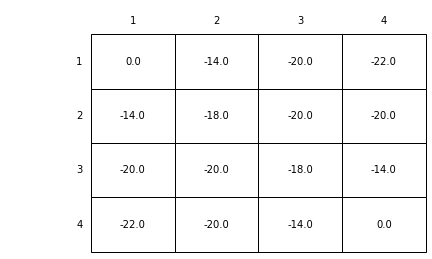

In [2]:
# While the author suggests using in-place iterative policy evaluation,
# Figure 4.1 actually uses out-of-place version.
_, asycn_iteration = compute_state_value(in_place=True)
values, sync_iteration = compute_state_value(in_place=False)
draw_image(np.round(values, decimals=2))
print('In-place: {} iterations'.format(asycn_iteration))
print('Synchronous: {} iterations'.format(sync_iteration))

## Policy Improvement

- The new policy is a strict improvement over $\pi$ unless $\pi$ is already optimal

## Policy Improvement theorem

$$
\begin{gather*}
q_\pi\left(s,\pi'(s)\right) \geq q_\pi\left(s,\pi(s)\right),\ \forall s\in\mathcal{S} \rightarrow \pi' \geq \pi \\
q_\pi\left(s,\pi'(s)\right) \gt q_\pi\left(s,\pi(s)\right),\text{ for all at least one }s\in\mathcal{S} \rightarrow \pi' \gt \pi
\end{gather*}
$$


## Policy Iteration

- *Policy Iteration* works by alternating *policy evaluation* and *policy improvement*
- Policy Iteration follows a sequence of *better and better policies and value functions* until it reaches the optimal policy and associated optimal value functions


## Example: Jack's Car Rental

In [3]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Aja Rangaswamy (aja004@gmail.com)                              #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################


import seaborn as sns
from scipy.stats import poisson

# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()


def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]


def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

max value change 196.62783361783852
max value change 134.98823859766583
max value change 91.41415360228919
max value change 67.17097732555729
max value change 51.29055484635097
max value change 38.49091000659837
max value change 29.406139835126424
max value change 25.7210573245398
max value change 22.381602293031023
max value change 19.40385808254939
max value change 16.77577350573091
max value change 14.47251552455765
max value change 12.464101852186843
max value change 10.719367983418692
max value change 9.20806226246873
max value change 7.9019189666795455
max value change 6.775146571130392
max value change 5.8045764710083745
max value change 4.969618520007145
max value change 4.252112693842776
max value change 3.6361309524054946
max value change 3.107761240497666
max value change 2.654891834022692
max value change 2.26700589940549
max value change 1.9349911763441128
max value change 1.650966802154585
max value change 1.4081276418079938
max value change 1.2006055672075036
max value c

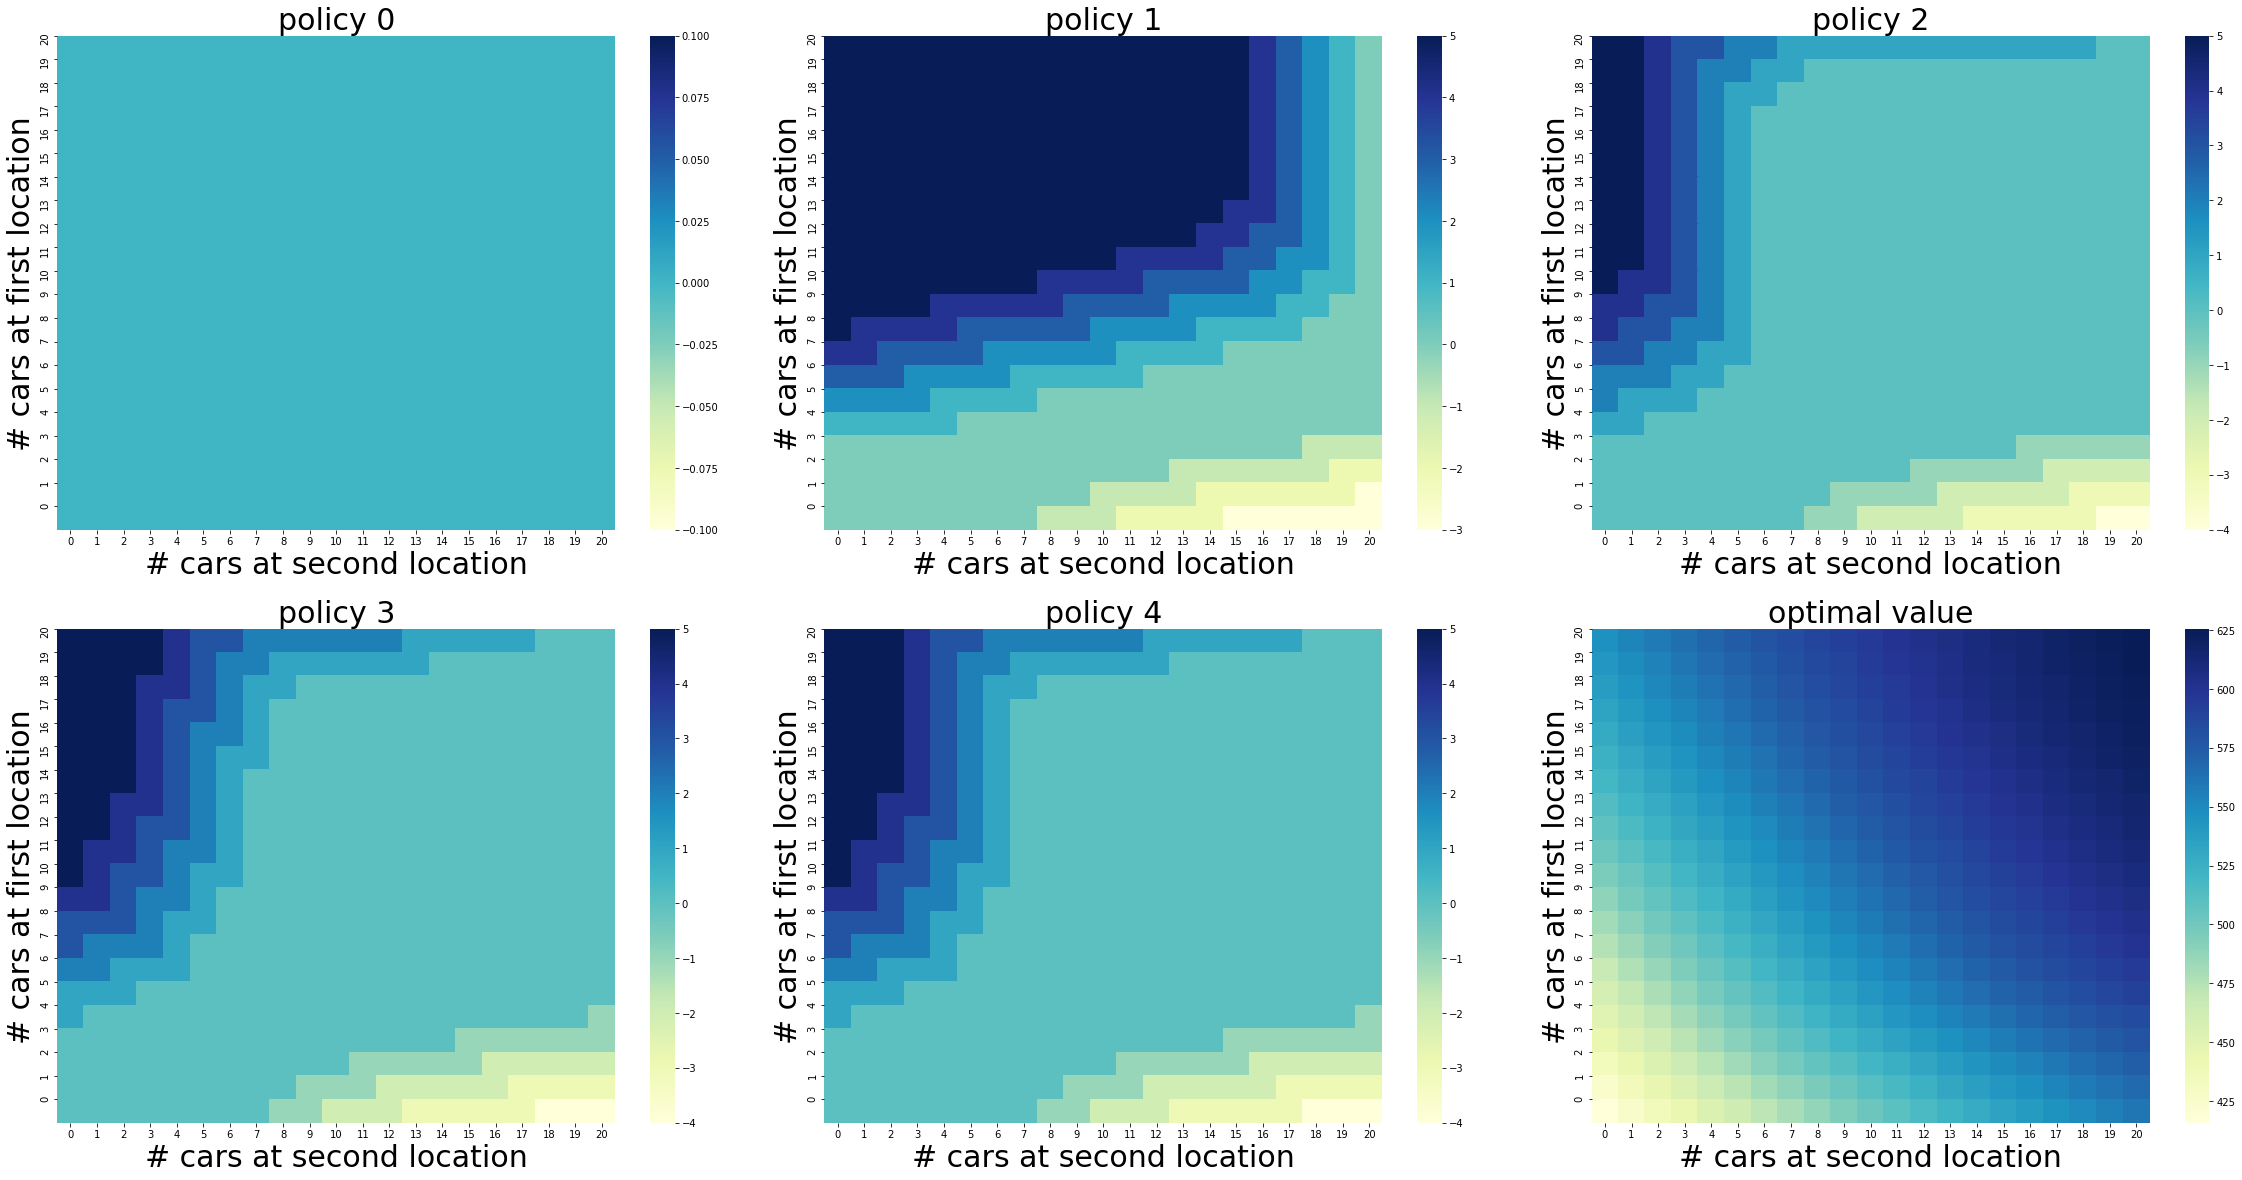

In [5]:
constant_returned_cars = True

value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
policy = np.zeros(value.shape, dtype=np.int)

iterations = 0
_, axes = plt.subplots(2, 3, figsize=(40, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()
while True:
    fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
    fig.set_ylabel('# cars at first location', fontsize=30)
    fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
    fig.set_xlabel('# cars at second location', fontsize=30)
    fig.set_title('policy {}'.format(iterations), fontsize=30)

    # policy evaluation (in-place)
    while True:
        old_value = value.copy()
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                new_state_value = expected_return([i, j], policy[i, j], value, constant_returned_cars)
                value[i, j] = new_state_value
        max_value_change = abs(old_value - value).max()
        print('max value change {}'.format(max_value_change))
        if max_value_change < 1e-4:
            break

    # policy improvement
    policy_stable = True
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i, j]
            action_returns = []
            for action in actions:
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                else:
                    action_returns.append(-np.inf)
            new_action = actions[np.argmax(action_returns)]
            policy[i, j] = new_action
            if policy_stable and old_action != new_action:
                policy_stable = False
    print('policy stable {}'.format(policy_stable))

    if policy_stable:
        fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('optimal value', fontsize=30)
        break

    iterations += 1


## Value Iteration

- *Value Iteration* allows us to combine policy evaluation and improvement into a single update
- *Asynchronous* dynamic programming methods give us the freedom to update states in any order
- *Generalized Policy Iteration* unifies classical DP methods, value iteration, and asynchronous DP

## Example: Gambler's Problem

Text(0, 0.5, 'Final policy (stake)')

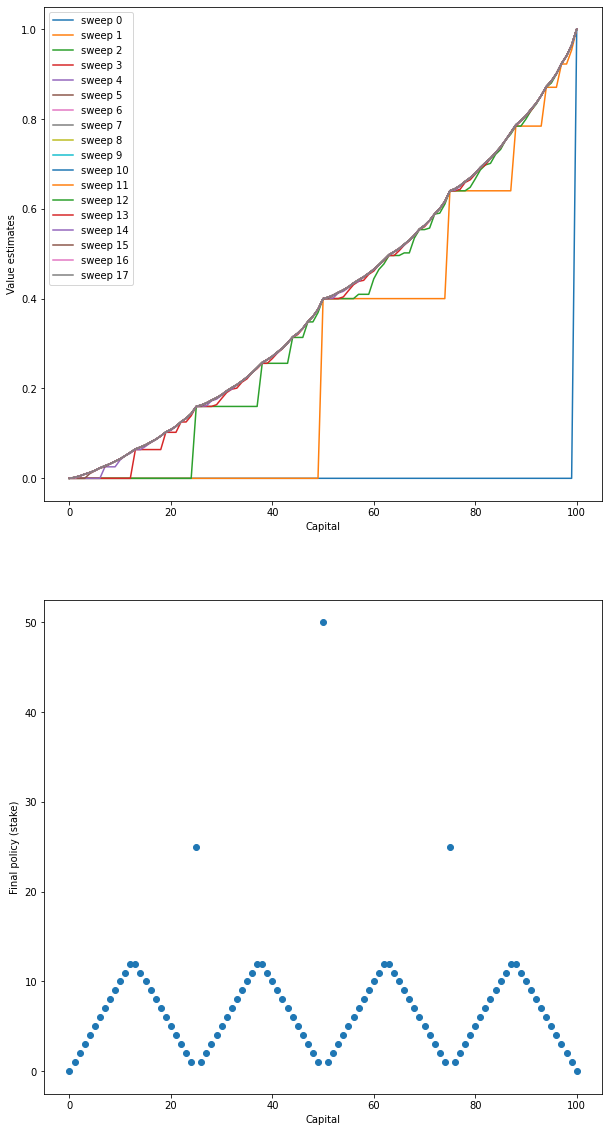

In [7]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

# goal
GOAL = 100

# all states, including state 0 and state 100
STATES = np.arange(GOAL + 1)

# probability of head
HEAD_PROB = 0.4

# state value
state_value = np.zeros(GOAL + 1)
state_value[GOAL] = 1.0

sweeps_history = []

# value iteration
while True:
    old_state_value = state_value.copy()
    sweeps_history.append(old_state_value)

    for state in STATES[1:GOAL]:
        # get possilbe actions for current state
        actions = np.arange(min(state, GOAL - state) + 1)
        action_returns = []
        for action in actions:
            action_returns.append(
                HEAD_PROB * state_value[state + action] + (1 - HEAD_PROB) * state_value[state - action])
        new_value = np.max(action_returns)
        state_value[state] = new_value
    delta = abs(state_value - old_state_value).max()
    if delta < 1e-9:
        sweeps_history.append(state_value)
        break

# compute the optimal policy
policy = np.zeros(GOAL + 1)
for state in STATES[1:GOAL]:
    actions = np.arange(min(state, GOAL - state) + 1)
    action_returns = []
    for action in actions:
        action_returns.append(
            HEAD_PROB * state_value[state + action] + (1 - HEAD_PROB) * state_value[state - action])

    # round to resemble the figure in the book, see
    # https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/issues/83
    policy[state] = actions[np.argmax(np.round(action_returns[1:], 5)) + 1]

plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1)
for sweep, state_value in enumerate(sweeps_history):
    plt.plot(state_value, label='sweep {}'.format(sweep))
plt.xlabel('Capital')
plt.ylabel('Value estimates')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.scatter(STATES, policy)
plt.xlabel('Capital')
plt.ylabel('Final policy (stake)')


## Efficiency of Dynamic Programming

- Policy Iteration: Polinomial time in $|\mathcal{S}|$ and $|\mathcal{A}|$
- Brute-Force Search: $|\mathcal{A}|^{|\mathcal{S}|}$ policies
- *Bootstrapping* can save us from performing a huge amount of unnecessary work